In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ner-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F761659%2F1432307%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240721%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240721T113955Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9d012c8a38994ec6e667e405dbd9f4b06b709c0eb76c84ac182671153048cb3faa109f2dca9ceb498ce65a9074d3ab92b6581acd4c430b2a161bd0a95dd6428d6736f415e6729c402bc00a63e91aac0619c6eba98a1136464c4db48fe0d9abe7bdcf96e276592fa082e517ffd638daada767696c325517ac9c26df343d73e9ac285a7eafbb363f9cb227184ed894f5c3bd7245fc8043c2099782e627151d7669b97311c263bd80ad88967e32b24d8c96cce18c0c89711b469f3e23fad7b15ca968d20e20afd487ed5546bfdcee096c701c60bcc99c39e5a7d8aca6ae853d10c98f81ce4ccb17223dd3848ecb70d5c52bc62c36d0052b5082ef9f9cc3a37168d2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3319509 bytes downloaded
Downloaded and uncompressed: ner-dataset
Data source import complete.


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/kaggle/input/ner-dataset/ner_datasetreference.csv", encoding='latin1')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
df = df.fillna(method='ffill')
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [ ]:
df["Tag"].value_counts()

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [ ]:
len(df["Tag"].value_counts())

17

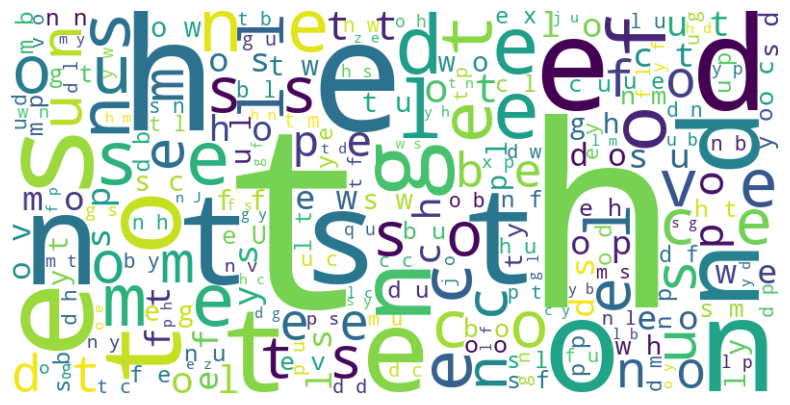

In [ ]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

text = ' '.join(df['Word'].apply(lambda x: ' '.join(x)).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

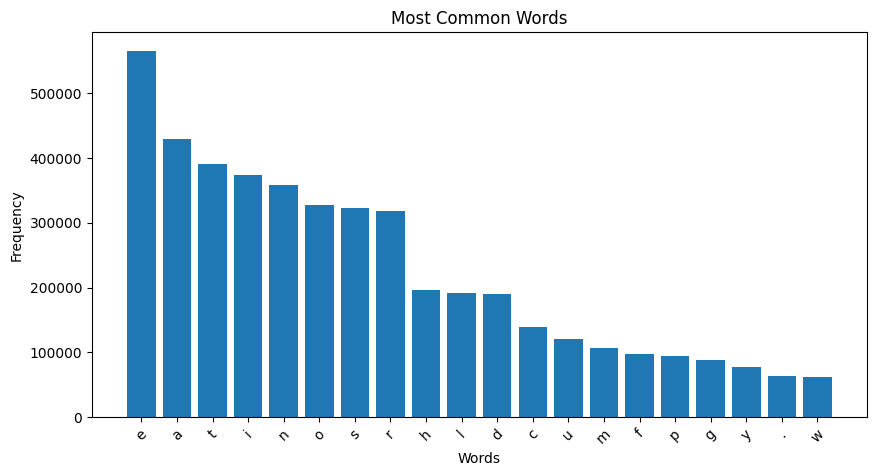

In [ ]:
all_words = [word for sublist in df['Word'] for word in sublist]
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df = df[:10000]
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
df.shape

(10000, 4)

In [ ]:
df['Tag'].value_counts()

Tag
O        8483
B-gpe     303
B-geo     244
I-per     206
B-org     176
B-per     160
B-tim     149
I-org     140
I-geo      31
B-art      28
I-art      20
I-gpe      20
I-tim      13
B-eve      10
I-eve      10
B-nat       5
I-nat       2
Name: count, dtype: int64

In [ ]:
df['POS'].value_counts()

POS
NN      1341
NNP     1286
IN      1186
DT       957
NNS      750
JJ       741
.        455
VBD      364
VBN      316
,        277
VBZ      264
VB       239
TO       217
CC       205
CD       199
VBP      185
RB       178
VBG      177
PRP      161
POS       96
MD        77
PRP$      72
``        38
WRB       38
WDT       33
JJS       28
JJR       26
RP        20
WP        17
NNPS      16
EX        10
RBR        8
:          5
$          5
RBS        4
LRB        3
RRB        3
PDT        2
WP$        1
Name: count, dtype: int64

In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

nltk.download('punkt')

sentences = df.groupby('Sentence #')['Word'].apply(list).values
tags = df.groupby('Sentence #')['Tag'].apply(list).values

all_words = [word for sentence in sentences for word in sentence]
all_tags = [tag for tag_list in tags for tag in tag_list]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
word2idx = {w: i + 2 for i, w in enumerate(set(all_words))}
word2idx['PAD'] = 0
word2idx['UNK'] = 1

tag2idx = {t: i + 1 for i, t in enumerate(set(all_tags))}
tag2idx['PAD'] = 0

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class NERDataset(Dataset):
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.tags[idx]
        words_idx = [word2idx.get(w, word2idx['UNK']) for w in words]
        tags_idx = [tag2idx[t] for t in tags]
        return torch.tensor(words_idx), torch.tensor(tags_idx)

def collate_fn(batch):
    words, tags = zip(*batch)
    words_lengths = torch.tensor([len(w) for w in words])
    tags_lengths = torch.tensor([len(t) for t in tags])

    words_padded = pad_sequence(words, batch_first=True, padding_value=word2idx['PAD'])
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=tag2idx['PAD'])

    return words_padded, tags_padded, words_lengths, tags_lengths

In [ ]:
sentences_train, sentences_test, tags_train, tags_test = train_test_split(sentences, tags, test_size=0.2, random_state=42)
train_dataset = NERDataset(sentences_train, tags_train)
test_dataset = NERDataset(sentences_test, tags_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
import torch
import torch.nn as nn

class NERModel(nn.Module):
    def __init__(self, vocab_size, tag_size, embedding_dim=100, hidden_dim=128):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx['PAD'])
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, tag_size)

    def forward(self, x, lengths):
        # Embedding layer
        x = self.embedding(x)
        # Packing the padded sequences
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed)
        # Unpacking the sequences
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # Linear layer
        x = self.fc(output)
        return x

In [ ]:
vocab_size = len(word2idx)
tag_size = len(tag2idx)
model = NERModel(vocab_size, tag_size)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx['PAD'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the model
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for words, tags, words_lengths, tags_lengths in train_loader:
        optimizer.zero_grad()
        outputs = model(words, words_lengths)
        outputs = outputs.view(-1, tag_size)
        tags = tags.view(-1)
        loss = criterion(outputs, tags)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')


Epoch 1/5, Loss: 2.5595737298329673
Epoch 2/5, Loss: 1.102462371190389
Epoch 3/5, Loss: 0.8342977265516917
Epoch 4/5, Loss: 0.7431969493627548
Epoch 5/5, Loss: 0.6860399842262268


In [ ]:
def calculate_accuracy(predictions, tags, tag2idx):
    pad_index = tag2idx['PAD']
    total_correct = 0
    total_tags = 0

    for pred_seq, tag_seq in zip(predictions, tags):
        # Remove padding from predictions and tags
        valid_indices = [i for i, t in enumerate(tag_seq) if t != pad_index]
        if valid_indices:
            correct_tags = sum([pred_seq[i] == tag_seq[i] for i in valid_indices])
            total_correct += correct_tags
            total_tags += len(valid_indices)

    accuracy = total_correct / total_tags if total_tags > 0 else 0
    return accuracy



In [ ]:
def remove_padding(seq, pad_index):
    return [item for item in seq if item != pad_index]

def print_predictions(words, true_tags, predicted_tags, word2idx, tag2idx):
    pad_index = tag2idx['PAD']

    for i in range(len(words)):
        word_list = [list(word2idx.keys())[list(word2idx.values()).index(w)] for w in words[i] if w != word2idx['PAD']]
        true_tag_list = remove_padding([list(tag2idx.keys())[list(tag2idx.values()).index(t)] for t in true_tags[i]], pad_index)
        pred_tag_list = remove_padding([list(tag2idx.keys())[list(tag2idx.values()).index(p)] for p in predicted_tags[i]], pad_index)

        # Print results
        print(f"Words: {' '.join(word_list)}")
        print(f"True Tags: {true_tag_list}")
        print(f"Predicted Tags: {pred_tag_list}")
        print(len(true_tag_list))
        print(len(pred_tag_list))
        print()

# Evaluate the LSTM model
model.eval()
total_accuracy = 0
num_batches = 0

with torch.no_grad():
    for words, tags, words_lengths, tags_lengths in test_loader:
        outputs = model(words, words_lengths)
        _, predictions = torch.max(outputs, dim=2)

        # Move tensors to CPU and convert to lists
        predictions = predictions.cpu().tolist()
        tags = tags.cpu().tolist()

        # Calculate accuracy
        accuracy = calculate_accuracy(predictions, tags, tag2idx)
        total_accuracy += accuracy
        num_batches += 1

        # Print some sample predictions
        print_predictions(words.cpu().tolist(), tags, predictions, word2idx, tag2idx)

        # Break after printing the first batch for brevity
        break

avg_accuracy = total_accuracy / num_batches
print(f'LSTM Test Accuracy: {avg_accuracy:.4f}')



Words: The two were killed in separate incidents as they walked home alone from elementary school along deserted roads .
True Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim', 'I-tim']
34
34

Words: He did not elaborate on why negotiators had come to the decision .
True Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-tim', 'I-tim', 'I-tim', 'I-tim